## 50 データの入手・整形

News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む． 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する． 抽出された事例をランダムに並び替える． 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）． 学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


KeyboardInterrupt: 

In [2]:
def extract_data(input_file):
    target_publisher_set = {"Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"}
    extracted_data = []
    with open(input_file, "r") as fi:
        for line in fi:
            data = line.rstrip("\n").split("\t")
            publisher = data[3]
            if publisher in target_publisher_set:
                extracted_data.append(data)

    return extracted_data

In [9]:
extracted_data = extract_data("./data/newsCorpora.csv")

In [10]:
import random
import os
from sklearn.model_selection import train_test_split


def split_data(extracted_data, output_dir):
    random.shuffle(extracted_data)
    train_data, valid_and_test_data = train_test_split(extracted_data, test_size=0.2)
    valid_data, test_data = train_test_split(valid_and_test_data, test_size=0.5)
    train_file = os.path.join(output_dir, "train.txt")
    valid_file = os.path.join(output_dir, "valid.txt")
    test_file = os.path.join(output_dir, "test.txt")
    with open(train_file, "w") as fo:
        for data in train_data:
            fo.write("{}\t{}\n".format(data[4], data[1]))
    with open(valid_file, "w") as fo:
        for data in valid_data:
            fo.write("{}\t{}\n".format(data[4], data[1]))
    with open(test_file, "w") as fo:
        for data in test_data:
            fo.write("{}\t{}\n".format(data[4], data[1]))

In [11]:
split_data(extracted_data, "work")

## 70 単語ベクトルの和による特徴量

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．

In [34]:
import numpy as np
from nltk.tokenize import word_tokenize

def convert_dataset_to_vector(word_vectors_model, input_file, label2id, x_output_file, y_output_file):
    x_vectors = []
    y_vectors = []
    
    with open(input_file, "r") as fi:
        for line in fi:
            text, label = line.rstrip("\n").split("\t")
            tokens = word_tokenize(text)
            vectors = []
            for token in tokens:
                try: # 単語ベクトルの中に含まれているものだけ抽出
                    vector = word_vectors_model[token]
                    vectors.append(vector)
                except KeyError:
                    continue
            if not vectors:
                continue
            ave_vector = np.mean(vectors, axis=0)
            x_vectors.append(ave_vector)
            label_id = label2id[label]
            y_vectors.append(label_id)
        x_vectors = np.array(x_vectors)
        y_vectors = np.array(y_vectors)
        
    print("x shape:{}\ty shape:{}".format(x_vectors.shape, y_vectors.shape))
    np.save(x_output_file, x_vectors)
    np.save(y_output_file, y_vectors)

In [35]:
from gensim.models import KeyedVectors
word_vectors_path = './data/GoogleNews-vectors-negative300.bin'
word_vectors_model = KeyedVectors.load_word2vec_format(word_vectors_path, binary=True)

In [36]:
label2id = {"b":0, "t":1, "e":2, "m":3}

In [37]:
convert_dataset_to_vector(word_vectors_model, "./data/train.txt", label2id, "./work/train_x.npy", "./work/train_y.npy")
convert_dataset_to_vector(word_vectors_model, "./data/valid.txt", label2id, "./work/valid_x.npy", "./work/valid_y.npy")
convert_dataset_to_vector(word_vectors_model, "./data/test.txt", label2id, "./work/test_x.npy", "./work/test_y.npy")

x shape:(10684, 300)	y shape:(10684,)
x shape:(1336, 300)	y shape:(1336,)
x shape:(1336, 300)	y shape:(1336,)


## 71. 単層ニューラルネットワークによる予測

In [38]:
import numpy as np
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, input_dim, num_class):
        super(Model, self).__init__()
        self.l1 = nn.Linear(input_dim, num_class, bias=False)

    def forward(self, x):
        logit = self.l1(x)
        return logit

In [39]:
model = Model(input_dim=300, num_class=4)
train_x = np.load("./work/train_x.npy")
train_y = np.load("./work/train_y.npy")
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
softmax = nn.Softmax(dim=-1)

In [40]:
y = softmax(model.forward(train_x[0]))
print(y)

tensor([0.2463, 0.2474, 0.2631, 0.2432], grad_fn=<SoftmaxBackward>)


In [41]:
y = softmax(model.forward(train_x[:4]))
print(y)

tensor([[0.2463, 0.2474, 0.2631, 0.2432],
        [0.2433, 0.2523, 0.2641, 0.2404],
        [0.2546, 0.2586, 0.2533, 0.2334],
        [0.2569, 0.2462, 0.2579, 0.2390]], grad_fn=<SoftmaxBackward>)


## 72. 損失と勾配の計算

In [42]:
import numpy as np
import torch
import torch.nn as nn


class Model(nn.Module):
    def __init__(self, input_dim, num_class):
        super(Model, self).__init__()
        self.l1 = nn.Linear(input_dim, num_class, bias=False)

    def forward(self, x):
        logit = self.l1(x)
        return logit

In [43]:
model = Model(input_dim=300, num_class=4)
train_x = np.load("./work/train_x.npy")
train_y = np.load("./work/train_y.npy")
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

In [44]:
loss_func = nn.CrossEntropyLoss(reduction='mean')
logit = model.forward(train_x[:4])
loss = loss_func(logit, train_y[:4])
print(loss)
loss.backward()
print(model.l1.weight.grad)

tensor(1.3753, grad_fn=<NllLossBackward>)
tensor([[-0.0362, -0.0386,  0.0032,  ...,  0.0012, -0.0091,  0.0117],
        [ 0.0194,  0.0118,  0.0119,  ..., -0.0111,  0.0052,  0.0020],
        [ 0.0029,  0.0008, -0.0059,  ...,  0.0058,  0.0012, -0.0024],
        [ 0.0138,  0.0260, -0.0093,  ...,  0.0042,  0.0028, -0.0113]])


## 73. 確率的勾配降下法による学習

In [45]:
from torch import optim


def train(output_file, num_epoch, train_x_file, train_y_file, learning_rate):
    train_x = np.load(train_x_file)
    train_y = np.load(train_y_file)
    train_x = torch.from_numpy(train_x)
    train_y = torch.from_numpy(train_y)
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    train_iter = torch.utils.data.DataLoader(train_dataset)
    model = Model(input_dim=300, num_class=4)
    loss_func = nn.CrossEntropyLoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    #訓練
    for epoch in range(1, num_epoch+1):
        total_loss = 0
        for x, y in train_iter:
            optimizer.zero_grad()
            logit = model.forward(x)
            loss = loss_func(logit, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        ave_loss = total_loss / len(train_x)
        print("Epoch:{}\tave_loss:{}".format(epoch, ave_loss))
    torch.save(model.state_dict(), output_file)

In [46]:
train("./work/model.pt", 10, "./work/train_x.npy", "./work/train_y.npy", 0.01)

Epoch:1	ave_loss:0.6828608990943538
Epoch:2	ave_loss:0.47088235313140053
Epoch:3	ave_loss:0.41033400815531706
Epoch:4	ave_loss:0.37844074632326846
Epoch:5	ave_loss:0.3582469477335565
Epoch:6	ave_loss:0.34403683642118316
Epoch:7	ave_loss:0.33333511975064123
Epoch:8	ave_loss:0.3248883714403976
Epoch:9	ave_loss:0.3179894401943489
Epoch:10	ave_loss:0.3122065503517621


## 74. 正解率の計測

In [47]:
from sklearn.metrics import accuracy_score


def evaluate(model_file, x_file, y_file):
    x_data = np.load(x_file)
    y_data = np.load(y_file)
    x_data = torch.from_numpy(x_data)
    y_data = torch.from_numpy(y_data)
    dataset = torch.utils.data.TensorDataset(x_data, y_data)
    data_iter = torch.utils.data.DataLoader(dataset)
    model = Model(input_dim=300, num_class=4)
    model.load_state_dict(torch.load(model_file)) # 訓練済みのモデルをロード
    softmax = nn.Softmax(dim=-1)
    gold_labels = []
    pred_labels = []
    for x, y in data_iter:
        logit = model.forward(x)
        pred_label = torch.argmax(softmax(logit), dim=-1)
        pred_labels.append(pred_label)
        gold_labels.append(y)
    accuracy = accuracy_score(gold_labels, pred_labels)
    
    return accuracy

In [48]:
train_acc = evaluate("./work/model.pt", "./work/train_x.npy", "./work/train_y.npy")
print("train accuracy:{}".format(train_acc))
test_acc = evaluate("./work/model.pt", "./work/test_x.npy", "./work/test_y.npy")
print("test accuracy:{}".format(test_acc))

train accuracy:0.8964807188318982
test accuracy:0.8952095808383234


## 75. 損失と正解率のプロット

In [49]:
import torch.nn as nn
from sklearn.metrics import accuracy_score
    

def calc_loss_and_accuracy(model, loss_func, dataset):
    softmax = nn.Softmax(dim=-1)
    gold_labels = []
    pred_labels = []
    total_loss = 0
    for x, y in dataset:
        logit = model.forward(x)
        loss = loss_func(logit, y)
        total_loss += loss.item()
        pred_label = torch.argmax(softmax(logit), dim=-1)
        pred_labels.append(pred_label)
        gold_labels.append(y)
    ave_loss = total_loss / len(dataset)
    accuracy = accuracy_score(gold_labels, pred_labels)
    
    return ave_loss, accuracy
    
    
def train(num_epoch, learning_rate, train_x_file, train_y_file, valid_x_file, valid_y_file, output_file, log_file):
    train_x = np.load(train_x_file)
    train_y = np.load(train_y_file)
    valid_x = np.load(valid_x_file)
    valid_y = np.load(valid_y_file)
    train_x = torch.from_numpy(train_x)
    train_y = torch.from_numpy(train_y)
    valid_x = torch.from_numpy(valid_x)
    valid_y = torch.from_numpy(valid_y)
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    valid_dataset = torch.utils.data.TensorDataset(valid_x, valid_y)
    train_iter = torch.utils.data.DataLoader(train_dataset)
    valid_iter = torch.utils.data.DataLoader(valid_dataset)
    model = Model(input_dim=300, num_class=4)
    loss_func = nn.CrossEntropyLoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    with open(log_file, "w") as f_log:
        f_log.write("{}\t{}\t{}\t{}\n".format("train_loss", "train_acc", "valid_loss", "valid_acc"))
        # 訓練
        print("Training Start")
        print("{}\t{}\t{}\t{}\t{}".format("Epoch", "Train_loss", "Train_acc", "Valid_loss", "Valid_acc"))
        for epoch in range(1, num_epoch+1):
            for x, y in train_iter:
                optimizer.zero_grad()
                logit = model.forward(x)
                loss = loss_func(logit, y)
                loss.backward()
                optimizer.step()
            # 評価
            train_loss, train_acc = calc_loss_and_accuracy(model, loss_func, train_iter)
            valid_loss, valid_acc = calc_loss_and_accuracy(model, loss_func, valid_iter)
            print("Epoch:{}\t{}\t{}\t{}\t{}".format(epoch, train_loss, train_acc, valid_loss, valid_acc))
            f_log.write("{}\t{}\t{}\t{}\n".format(train_loss, train_acc, valid_loss, valid_acc))
        torch.save(model.state_dict(), output_file)

In [58]:
train(10, 0.01, "./work/train_x.npy", "./work/train_y.npy", "./work/valid_x.npy", "./work/valid_y.npy", "./work/model75.pt", "./work/log75.txt")

Training Start
Epoch	Train_loss	Train_acc	Valid_loss	Valid_acc
Epoch:1	0.5213235759294037	0.8157057281916885	0.5350950387875343	0.8016467065868264
Epoch:2	0.4324924043759599	0.8558592287532759	0.44756538830748077	0.8383233532934131
Epoch:3	0.39094242936432577	0.871115687008611	0.4073476682476871	0.8592814371257484
Epoch:4	0.3662719346086843	0.88131785847997	0.3840342477722592	0.8675149700598802
Epoch:5	0.34959537736403995	0.8861849494571321	0.36872050971194625	0.8735029940119761
Epoch:6	0.3373740580638377	0.8901160614002246	0.357857820356286	0.875
Epoch:7	0.3279155810524871	0.8920816173717708	0.3497464616225688	0.8794910179640718
Epoch:8	0.3203038599396507	0.8939535754399102	0.3434645534345261	0.8824850299401198
Epoch:9	0.3139967526661416	0.8949831523773868	0.3384657861250034	0.8824850299401198
Epoch:10	0.30865123424859964	0.8956383377012355	0.334404398213687	0.8824850299401198


In [54]:
# pandasでグラフ作成
import pandas as pd
df = pd.read_csv("./work/log.txt", sep="\t")

In [55]:
df.head()

,train_loss,train_acc,valid_loss,valid_acc
0,0.517239,0.823662,0.525421,0.827844
1,0.429146,0.862411,0.441278,0.863772
2,0.387735,0.876638,0.403713,0.878743
3,0.363047,0.884875,0.382318,0.884731
4,0.346310,0.889274,0.368379,0.889222


Text(0, 0.5, 'Accuracy')

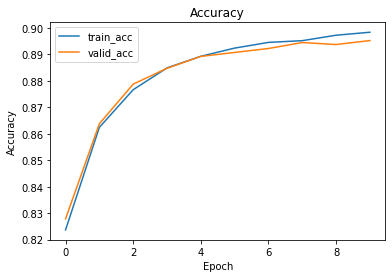

In [62]:
ax = df[["train_acc", "valid_acc"]].plot()
ax.set_title("Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

Text(0, 0.5, 'Loss')

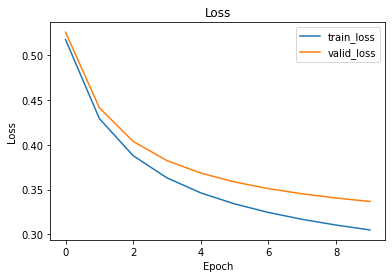

In [63]:
ax = df[["train_loss", "valid_loss"]].plot()
ax.set_title("Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training

In [96]:
import torch.nn as nn
from sklearn.metrics import accuracy_score

#チェックポイントとして、重み行列の値と最適化アルゴリズムの内部状態をファイルに書き込む        
def calc_loss_and_accuracy(model, loss_func, dataset):
    softmax = nn.Softmax(dim=-1)
    gold_labels = []
    pred_labels = []
    total_loss = 0
    for x, y in dataset:
        logit = model.forward(x)
        loss = loss_func(logit, y)
        total_loss += loss.item()
        pred_label = torch.argmax(softmax(logit), dim=-1)
        pred_labels.append(pred_label)
        gold_labels.append(y)
    ave_loss = total_loss / len(dataset)
    accuracy = accuracy_score(gold_labels, pred_labels)
    
    return ave_loss, accuracy
    
def train(num_epoch, learning_rate, train_x_file, train_y_file, valid_x_file, valid_y_file, output_file, log_file):
    train_x = np.load(train_x_file)
    train_y = np.load(train_y_file)
    valid_x = np.load(valid_x_file)
    valid_y = np.load(valid_y_file)
    train_x = torch.from_numpy(train_x)
    train_y = torch.from_numpy(train_y)
    valid_x = torch.from_numpy(valid_x)
    valid_y = torch.from_numpy(valid_y)
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    valid_dataset = torch.utils.data.TensorDataset(valid_x, valid_y)
    train_iter = torch.utils.data.DataLoader(train_dataset)
    valid_iter = torch.utils.data.DataLoader(valid_dataset)
    model = Model(input_dim=300, num_class=4)
    loss_func = nn.CrossEntropyLoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    with open(log_file, "w") as f_log:
        f_log.write("{}\t{}\t{}\t{}\n".format("train_loss", "train_acc", "valid_loss", "valid_acc"))
        # 訓練
        print("Training Start")
        print("{}\t{}\t{}\t{}\t{}".format("Epoch", "Train_loss", "Train_acc", "Valid_loss", "Valid_acc"))
        for epoch in range(1, num_epoch+1):
            for x, y in train_iter:
                optimizer.zero_grad()
                logit = model.forward(x)
                loss = loss_func(logit, y)
                loss.backward()
                optimizer.step()
            # 評価
            train_loss, train_acc = calc_loss_and_accuracy(model, loss_func, train_iter)
            valid_loss, valid_acc = calc_loss_and_accuracy(model, loss_func, valid_iter)
            print("Epoch:{}\t{}\t{}\t{}\t{}".format(epoch, train_loss, train_acc, valid_loss, valid_acc))
            f_log.write("{}\t{}\t{}\t{}\n".format(train_loss, train_acc, valid_loss, valid_acc))
            
        #model.state_dictメソッドでモデルのパラメータを保存できる
        #optimizer.state_dict()→内部状態を保存するメソッド
        torch.save({'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict()} , output_file)

In [97]:
train(10, 0.01, "./work/train_x.npy", "./work/train_y.npy", "./work/valid_x.npy", "./work/valid_y.npy", "./work/model76.pt", "./work/log76.txt")

Training Start
Epoch	Train_loss	Train_acc	Valid_loss	Valid_acc
Epoch:1	0.5203304422622188	0.8154249344814676	0.5337872897260153	0.8016467065868264
Epoch:2	0.4317631861800417	0.8571695994009734	0.4467609699394073	0.8398203592814372
Epoch:3	0.3904088094642346	0.8713028828154249	0.40682386865145403	0.8592814371257484
Epoch:4	0.3658613336122126	0.8817858479970049	0.38366374280708904	0.8667664670658682
Epoch:5	0.3492659562953289	0.8872145263946087	0.36844050845793447	0.8712574850299402
Epoch:6	0.3371012263329376	0.8897416697865967	0.3576352159457773	0.875
Epoch:7	0.32768406134240063	0.8926432047922127	0.34956237789002786	0.8787425149700598
Epoch:8	0.3201036311475094	0.8939535754399102	0.3433077363987279	0.8824850299401198
Epoch:9	0.31382092654684485	0.8950767502807937	0.33832918288913094	0.8832335329341318
Epoch:10	0.30849491294242976	0.8963871209284912	0.3342832680263817	0.8832335329341318


In [98]:
#ファイルを読み込んで確認
output_f = "./work/model76.pt"
check_point = torch.load(output_f)
print(check_point)

{'model_state_dict': OrderedDict([('l1.weight', tensor([[-0.4233, -0.0917, -0.1502,  ...,  0.2818,  0.2262, -0.7437],
        [ 0.3361,  0.1776,  0.5988,  ..., -0.0393, -0.6740, -0.4723],
        [ 0.5205,  0.0892, -1.0334,  ..., -0.6633,  0.0559,  0.3182],
        [-0.3700, -0.1506,  0.5157,  ...,  0.3028,  0.4610,  0.8636]]))]), 'optimizer_state_dict': {'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0]}]}}


# 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [153]:
#パラメータの更新に全ての訓練データを用いるのがバッチ学習
#それに対して一部の訓練データを取り出すのがミニバッチ学習

import time
def calc_loss_and_accuracy(model, loss_func, dataset):
    softmax = nn.Softmax(dim=-1)
    gold_labels = []
    pred_labels = []
    total_loss = 0
    
    for x, y in dataset:
        logit = model.forward(x)
        loss = loss_func(logit, y)
        total_loss += loss.item()
        pred_label = torch.argmax(softmax(logit), dim=-1)
        pred_labels.append(pred_label)
        gold_labels.append(y)
    ave_loss = total_loss / len(dataset)
    accuracy = accuracy_score(gold_labels, pred_labels)
    
    return ave_loss, accuracy
      
def train(batch_size, num_epoch, learning_rate, train_x_file, train_y_file, valid_x_file, valid_y_file, output_file, log_file):
    train_x = np.load(train_x_file)
    train_y = np.load(train_y_file)
    valid_x = np.load(valid_x_file)
    valid_y = np.load(valid_y_file)
    train_x = torch.from_numpy(train_x).float()
    train_y = torch.from_numpy(train_y).long()
    valid_x = torch.from_numpy(valid_x).float()
    valid_y = torch.from_numpy(valid_y).long()
    
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    valid_dataset = torch.utils.data.TensorDataset(valid_x, valid_y)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    valid_iter = torch.utils.data.DataLoader(valid_dataset)
    model = Model(input_dim=300, num_class=4)
    loss_func = nn.CrossEntropyLoss(reduction='mean')
    
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    with open(log_file, "w") as f_log:
        f_log.write("{}\n".format("batch_size"))
        # 訓練 
        for epoch in range(1, num_epoch+1):
            
            #時間を記録
            start = time.time()
            for x, y in train_iter:
                optimizer.zero_grad()
                logit = model.forward(x)
                loss = loss_func(logit, y)
                loss.backward()
                optimizer.step()
            
            #終了時刻
            end = time.time()
            total_time = end - start
            print("Batch_size:{}\t{}".format(batch_size, total_time))
            f_log.write("{}\t{}\n".format(batch_size, total_time))
            
        #model.state_dictメソッドでモデルのパラメータを保存できる
        #optimizer.state_dict()→内部状態を保存するメソッド
        torch.save({'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict()} , output_file)

In [155]:
#バッチサイズを指定
for batch_size in [ 2 ** i for i in range(10)]:
    train(batch_size, 1, 0.01, "./work/train_x.npy", "./work/train_y.npy", "./work/valid_x.npy", "./work/valid_y.npy"model, "./work/model77.pt", "./work/log77.txt")

Batch_size:1	2.2845213413238525
Batch_size:2	1.2452478408813477
Batch_size:4	0.6073892116546631
Batch_size:8	0.35704827308654785
Batch_size:16	0.23964905738830566
Batch_size:32	0.16015195846557617
Batch_size:64	0.12971782684326172
Batch_size:128	0.13903307914733887
Batch_size:256	0.10283017158508301
Batch_size:512	0.09129524230957031


# 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

* 乾研サーバーの環境構築が終わっていなかった為割愛

In [ ]:
#学習に要する時間の表示

# 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [201]:
import torch.nn.functional as F
#多層化したモデルの定義(隠れ層を追加)
class Multipled_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Multipled_model, self).__init__()
        #Linearは全結合層を示す
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    #forward pass
    def forward(self, x):
        x = F.relu(self.fc1(x))
        logit = self.fc2(x)
        return logit

In [ ]:
import torch.nn as nn
from sklearn.metrics import accuracy_score

def calc_loss_and_accuracy(model, loss_func, dataset):
    softmax = nn.Softmax(dim=-1)
    gold_labels = []
    pred_labels = []
    total_loss = 0
    for x, y in dataset:
        logit = model.forward(x)
        loss = loss_func(logit, y)
        total_loss += loss.item()
        pred_label = torch.argmax(softmax(logit), dim=-1)
        pred_labels.append(pred_label)
        gold_labels.append(y)
    ave_loss = total_loss / len(dataset)
    accuracy = accuracy_score(gold_labels, pred_labels)
    
    return ave_loss, accuracy
    
def train(batch_size, num_epoch, learning_rate, train_x_file, train_y_file, valid_x_file, valid_y_file, output_file, log_file):
    train_x = np.load(train_x_file)
    train_y = np.load(train_y_file)
    valid_x = np.load(valid_x_file)
    valid_y = np.load(valid_y_file)
    train_x = torch.from_numpy(train_x).float()
    train_y = torch.from_numpy(train_y).long()
    valid_x = torch.from_numpy(valid_x).float()
    valid_y = torch.from_numpy(valid_y).long()
    
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    valid_dataset = torch.utils.data.TensorDataset(valid_x, valid_y)
    train_iter = torch.utils.data.DataLoader(train_dataset,shuffle = True)
    valid_iter = torch.utils.data.DataLoader(valid_dataset)
    model = Multipled_model(input_dim=300, hidden_dim=100,output_dim=4)
    loss_func = nn.CrossEntropyLoss(reduction='mean')
    
    #optimizerを変更
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
         
    with open(log_file, "w") as f_log:
        f_log.write("{}\t{}\t{}\t{}\n".format("train_loss", "train_acc", "valid_loss", "valid_acc"))
        # 訓練 
        print("{}\t{}\t{}\t{}\t{}".format("Epoch", "Train_loss", "Train_acc", "Valid_loss", "Valid_acc"))
        for epoch in range(1, num_epoch+1):
            
            for x, y in train_iter:
                optimizer.zero_grad()
                logit = model(x)
                loss = loss_func(logit, y)
                loss.backward()
                optimizer.step()
                
            #評価
            train_loss, train_acc = calc_loss_and_accuracy(model, loss_func, train_iter)
            valid_loss, valid_acc = calc_loss_and_accuracy(model, loss_func, valid_iter)
            print("Epoch:{}\t{}\t{}\t{}\t{}".format(epoch, train_loss, train_acc, valid_loss, valid_acc))
            f_log.write("{}\t{}\t{}\t{}\n".format(train_loss, train_acc, valid_loss, valid_acc))
            
        #model.state_dictメソッドでモデルのパラメータを保存できる
        #optimizer.state_dict()→内部状態を保存するメソッド
        torch.save({'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict()} , output_file)

In [214]:
train(256, 100, 0.01, "./work/train_x.npy", "./work/train_y.npy", "./work/valid_x.npy", "./work/valid_y.npy", "./work/model79.pt", "./work/log79.txt")

Epoch	Train_loss	Train_acc	Valid_loss	Valid_acc
Epoch:1	0.2857771837839182	0.9041557469112692	0.3809893997890397	0.8869760479041916
Epoch:2	0.31657333208247185	0.8925496068888057	0.4296295026250836	0.8712574850299402
Epoch:3	0.2501529350781316	0.9181954324223137	0.39222289153820217	0.8862275449101796
Epoch:4	0.22686568033961552	0.9208161737177087	0.376537689733234	0.8907185628742516
Epoch:5	0.23717222906005192	0.9213777611381505	0.509250994178514	0.8787425149700598
Epoch:6	0.24779755275363682	0.9281168101834519	0.5371936573470764	0.8899700598802395
Epoch:7	0.19492646393880142	0.9287719955073006	0.4646183300114005	0.8899700598802395
Epoch:8	0.20463245939227612	0.9204417821040809	0.529132636401041	0.8675149700598802
Epoch:9	0.17043693858159875	0.9417821040808686	0.5886486208180495	0.8817365269461078
Epoch:10	0.15687281495447813	0.9480531636091352	0.6497314538800224	0.8839820359281437
Epoch:11	0.1673355713754052	0.9475851740921003	0.6982767493958552	0.8802395209580839
Epoch:12	0.144150031

In [216]:
import torch.nn as nn
from sklearn.metrics import accuracy_score

def calc_loss_and_accuracy(model, loss_func, dataset):
    softmax = nn.Softmax(dim=-1)
    gold_labels = []
    pred_labels = []
    total_loss = 0
    for x, y in dataset:
        logit = model.forward(x)
        loss = loss_func(logit, y)
        total_loss += loss.item()
        pred_label = torch.argmax(softmax(logit), dim=-1)
        pred_labels.append(pred_label)
        gold_labels.append(y)
    ave_loss = total_loss / len(dataset)
    accuracy = accuracy_score(gold_labels, pred_labels)
    
    return ave_loss, accuracy
    
def train(batch_size, num_epoch, learning_rate, train_x_file, train_y_file, valid_x_file, valid_y_file, output_file, log_file):
    train_x = np.load(train_x_file)
    train_y = np.load(train_y_file)
    valid_x = np.load(valid_x_file)
    valid_y = np.load(valid_y_file)
    train_x = torch.from_numpy(train_x).float()
    train_y = torch.from_numpy(train_y).long()
    valid_x = torch.from_numpy(valid_x).float()
    valid_y = torch.from_numpy(valid_y).long()
    
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    valid_dataset = torch.utils.data.TensorDataset(valid_x, valid_y)
    train_iter = torch.utils.data.DataLoader(train_dataset,shuffle = True)
    valid_iter = torch.utils.data.DataLoader(valid_dataset)
    model = Multipled_model(input_dim=300, hidden_dim=100,output_dim=4)
    loss_func = nn.CrossEntropyLoss(reduction='mean')
    
    #optimizerを変更
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
         
    with open(log_file, "w") as f_log:
        f_log.write("{}\t{}\t{}\t{}\n".format("train_loss", "train_acc", "valid_loss", "valid_acc"))
        # 訓練 
        print("{}\t{}\t{}\t{}\t{}".format("Epoch", "Train_loss", "Train_acc", "Valid_loss", "Valid_acc"))
        for epoch in range(1, num_epoch+1):
            
            for x, y in train_iter:
                optimizer.zero_grad()
                logit = model(x)
                loss = loss_func(logit, y)
                loss.backward()
                optimizer.step()
                
            #評価
            train_loss, train_acc = calc_loss_and_accuracy(model, loss_func, train_iter)
            valid_loss, valid_acc = calc_loss_and_accuracy(model, loss_func, valid_iter)
            print("Epoch:{}\t{}\t{}\t{}\t{}".format(epoch, train_loss, train_acc, valid_loss, valid_acc))
            f_log.write("{}\t{}\t{}\t{}\n".format(train_loss, train_acc, valid_loss, valid_acc))
            
        #model.state_dictメソッドでモデルのパラメータを保存できる
        #optimizer.state_dict()→内部状態を保存するメソッド
        torch.save({'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict()} , output_file)

In [ ]:
#GPU上で学習した結果を表示